In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')#ignore warnings in program

#import datasets

customer = pd.read_csv('olist_customers_dataset.csv')
location =  pd.read_csv('olist_geolocation_dataset.csv')
order_item = pd.read_csv('olist_order_items_dataset.csv')
order = pd.read_csv('olist_orders_dataset.csv')
payment = pd.read_csv('olist_order_payments_dataset.csv')
review = pd.read_csv('olist_order_reviews_dataset.csv')
product = pd.read_csv('olist_products_dataset.csv')
seller = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# Use the .duplicated() method to find duplicated rows based on all columns
duplicates = location[location.duplicated(keep='last')]

#remove duplicated rows
location_no_dup = location.drop_duplicates()
#limit the range locations to remove noise and increase accuracy of the locations
new_location = location[(location['geolocation_lat'] >-50) &
                        (location['geolocation_lat']<10)&
                        (location['geolocation_lng']>-80)&
                        (location['geolocation_lng']<-35)]

In [3]:
# Merge the two dataframes on the common columns 'product_category name' 
merged_df = product.merge(translation, left_on='product_category_name', right_on='product_category_name', how='left')

# Drop the redundant 'Zip_Prefix' column
merged_df.drop(columns=['product_category_name'], inplace=True)

# Merge the two dataframes on the common columns 'product_id' 
merged_product_name = merged_df.merge(order_item, left_on='product_id', right_on='product_id', how='left')

# Drop the redundant column
merged_product_name.drop(columns=['product_id'], inplace=True)
merged_product_name.drop(columns=['product_name_lenght', 'product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm'], inplace=True)
data_column=merged_product_name['product_category_name_english']

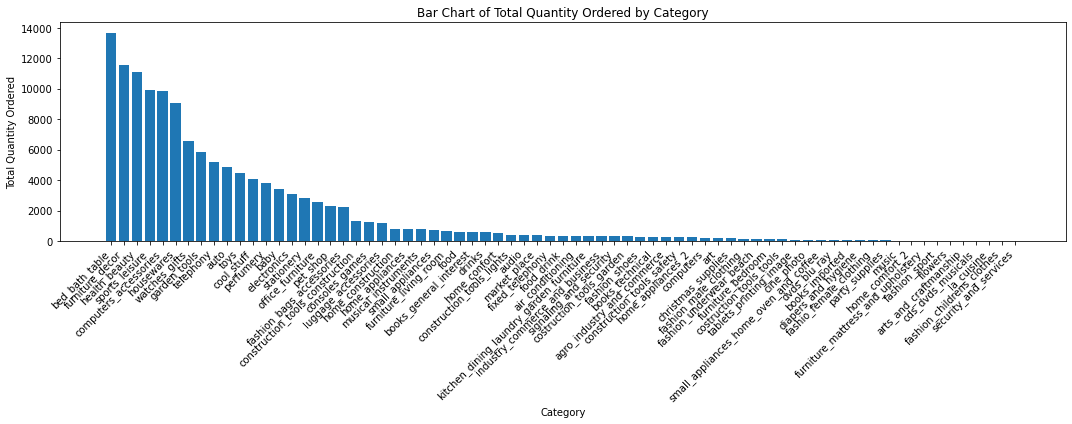

In [4]:
# Group the data by 'Category_Name' and sum the 'Quantity' for each category
category_quantities = merged_product_name.groupby('product_category_name_english')['order_item_id'].sum().reset_index()
# Sort the categories by quantity in descending order
category_quantities = category_quantities.sort_values(by='order_item_id', ascending=False)

# Create a bar chart
plt.figure(figsize=(15, 6))  # Set the figure size

# Plot the bars for each category and its corresponding quantity
plt.bar(category_quantities['product_category_name_english'], category_quantities['order_item_id'])

plt.xlabel('Category')
plt.ylabel('Total Quantity Ordered')
plt.title('Bar Chart of Total Quantity Ordered by Category')

# Rotate the category labels for better readability
plt.xticks(rotation=45, ha='right')
bar_width= 8
spacing = 8
plt.tight_layout()  # Adjust layout for better label display

plt.show()

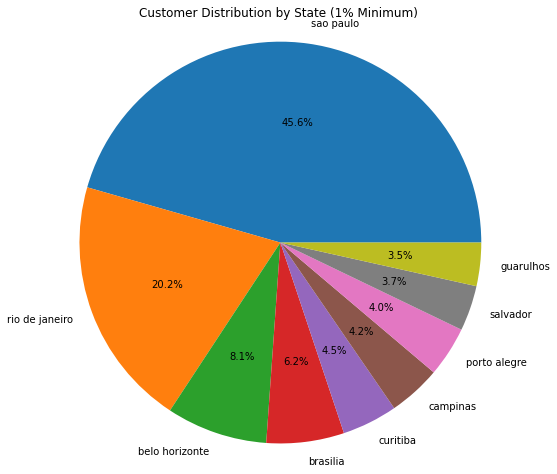

In [5]:
# Count customers in each city
city_counts = customer['customer_city'].value_counts()

#set treshold to 1%
threshold = 0.01 

# cities with customer population less than 1%
small_cities = city_counts[city_counts / city_counts.sum() < threshold]

# cities with customer population greater than 1%
big_city = city_counts[city_counts /city_counts.sum() >= threshold]


# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(big_city, labels=big_city.index, autopct='%1.1f%%')

plt.axis('equal')
plt.title('Customer Distribution by State (1% Minimum)')
plt.show()

In [19]:
#merge payment and order_item datasframe to make get the payment value for each order
sales = pd.merge(payment, order_item, on='order_id', how='inner')
# Merge the result with the 'order' DataFrame to get the date of purchase of each order
sales = pd.merge(sales, order, on='order_id', how='inner')
sales = pd.merge(sales, product, on= 'product_id', how = 'inner')

# Merge the two dataframes on the common columns 'product_category name' 
sales = pd.merge(sales, translation, on='product_category_name', how= 'inner')

# # Drop the redundant 'Zip_Prefix' column
sales.drop(columns=['product_category_name'], inplace=True)

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115878 entries, 0 to 115877
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115878 non-null  object 
 1   payment_sequential             115878 non-null  int64  
 2   payment_type                   115878 non-null  object 
 3   payment_installments           115878 non-null  int64  
 4   payment_value                  115878 non-null  float64
 5   order_item_id                  115878 non-null  int64  
 6   product_id                     115878 non-null  object 
 7   seller_id                      115878 non-null  object 
 8   shipping_limit_date            115878 non-null  object 
 9   price                          115878 non-null  float64
 10  freight_value                  115878 non-null  float64
 11  customer_id                    115878 non-null  object 
 12  order_status                  

In [7]:
from mlxtend.frequent_patterns import association_rules, apriori


# Convert product_category_name to a list of lists (transactions)
transactions = sales.pivot_table(index='order_id',columns ='product_category_name_english',values = 'order_item_id',aggfunc='sum').fillna(0)

def encode(x):
    if x <=0:
        return 0
    else:
        return 1
df_pivot = transactions.applymap(encode)

support = 0.00001
frequent_items = apriori(df_pivot, min_support=support, use_colnames=True)
frequent_items.sort_values('support', ascending=False)


metric = 'lift'
min_treshold = 0.00001

rules = association_rules(frequent_items, metric=metric, min_threshold=min_treshold)[['antecedents','consequents','support','confidence','lift']]
rules.reset_index(drop=True).sort_values('confidence',ascending=False, inplace = True)
rules

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
0,(computers_accessories),(air_conditioning),0.000010,0.000149,0.057469
1,(air_conditioning),(computers_accessories),0.000010,0.003953,0.057469
2,(sports_leisure),(air_conditioning),0.000010,0.000130,0.049794
3,(air_conditioning),(sports_leisure),0.000010,0.003953,0.049794
4,(furniture_decor),(art),0.000051,0.000775,0.373283
...,...,...,...,...,...
569,"(furniture_decor, pet_shop)",(sports_leisure),0.000010,0.500000,6.298899
570,"(sports_leisure, pet_shop)",(furniture_decor),0.000010,1.000000,15.080633
571,(furniture_decor),"(sports_leisure, pet_shop)",0.000010,0.000155,15.080633
572,(sports_leisure),"(furniture_decor, pet_shop)",0.000010,0.000130,6.298899


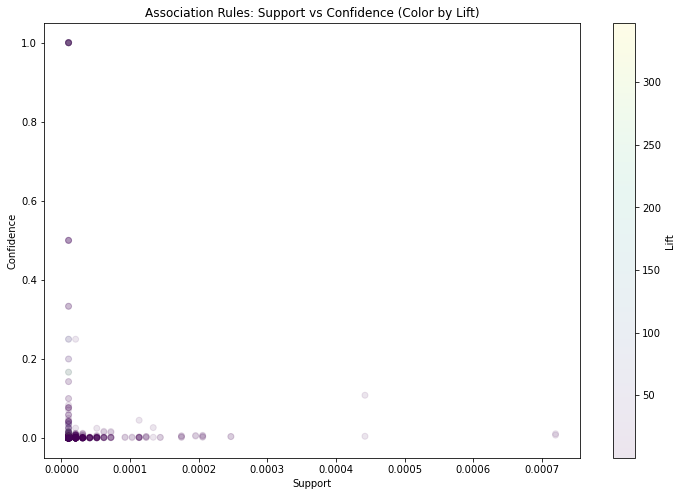

In [8]:
# Scatter plot rules by support, confidence, and color by lift
plt.figure(figsize=(12, 8))
scatter = plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='viridis', alpha=0.1)

# Add colorbar
plt.colorbar(scatter, label='Lift')

# Set labels and title
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (Color by Lift)')

plt.show()

In [9]:
customer_sales = pd.merge(payment, order, on='order_id')
columns_to_drop = ['order_id','payment_sequential','payment_installments','payment_type','order_status','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
customer_sales.drop(columns= columns_to_drop , inplace=True)

# Group by 'customer_id' and sum the prices
customer_sales = customer_sales.groupby('customer_id')['payment_value'].sum().reset_index()



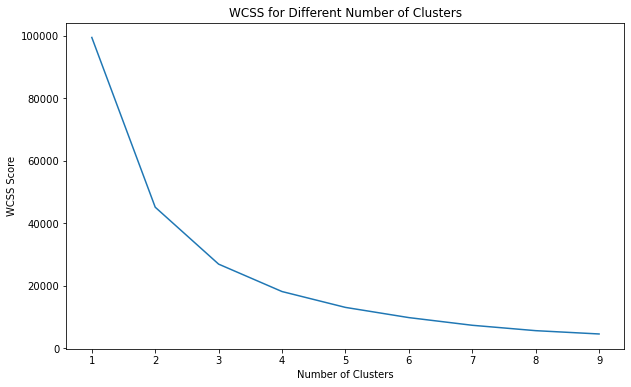

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

wcss = []
score =[]

sample = ['payment_value']

# Extracting features for clustering
X = customer_sales[sample]

scaler = StandardScaler(with_mean = False)

#standardize the data
X_scaled = scaler.fit_transform(X)


# Determine the optimal number of clusters using wcss
for n_clusters in range(1, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    pred_kmean = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)


# Plotting the WCSS grapg
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10),wcss)
plt.title('WCSS for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS Score')
plt.show()

Cluster 1 Mean: 109.62774316927654
Cluster 2 Mean: 1721.245389473684
Cluster 3 Mean: 492.7917216627383


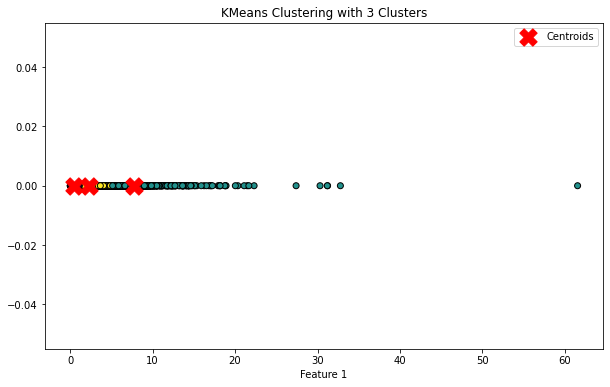

In [24]:

# Apply KMeans with the specified number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
pred_kmean = kmeans.fit_predict(X_scaled)

# Recalculate the mean for each cluster
cluster_centers_scaled = kmeans.cluster_centers_

# Transform the scaled cluster centers back to the original scale
cluster_centers_original_scale = scaler.inverse_transform(cluster_centers_scaled)

# Create a DataFrame to store the results
cluster_means_df = pd.DataFrame(cluster_centers_original_scale, columns=sample)

# Print the mean for each cluster
for cluster_num, mean_values in enumerate(cluster_means_df.iterrows(), 1):
    print(f"Cluster {cluster_num} Mean: {mean_values[1]['payment_value']}")

# Plotting the KMeans clusters with the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], [0] * len(X_scaled), c=pred_kmean_optimal, cmap='viridis', edgecolors='k')
plt.scatter(kmeans_optimal.cluster_centers_[:, 0], [0] * 3, s=300, c='red', marker='X', label='Centroids')
plt.title(f'KMeans Clustering with 3 Clusters')
plt.xlabel('Feature 1')
plt.legend()
plt.show()

In [12]:
def classify_cat(x):
    if x in ['office_furniture', 'furniture_decor', 'furniture_living_room', 'kitchen_dining_laundry_garden_furniture', 'bed_bath_table', 'home_comfort', 'home_comfort_2', 'home_construction', 'garden_tools', 'furniture_bedroom', 'furniture_mattress_and_upholstery']:
        return 'Furniture'
    
    elif x in ['auto', 'computers_accessories', 'musical_instruments', 'consoles_games', 'watches_gifts', 'air_conditioning', 'telephony', 'electronics', 'fixed_telephony', 'tablets_printing_image', 'computers', 'small_appliances_home_oven_and_coffee', 'small_appliances', 'audio', 'signaling_and_security', 'security_and_services']:
        return 'Electronics'
    
    elif x in ['fashio_female_clothing', 'fashion_male_clothing', 'fashion_bags_accessories', 'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach', 'fashion_childrens_clothes', 'baby', 'cool_stuff', ]:
        return 'Fashion'
    
    elif x in ['housewares', 'home_confort', 'home_appliances', 'home_appliances_2', 'flowers', 'costruction_tools_garden', 'garden_tools', 'construction_tools_lights', 'costruction_tools_tools', 'luggage_accessories', 'la_cuisine', 'pet_shop', 'market_place']:
        return 'Home & Garden'
    
    elif x in ['sports_leisure', 'toys', 'cds_dvds_musicals', 'music', 'dvds_blu_ray', 'cine_photo', 'party_supplies', 'christmas_supplies', 'arts_and_craftmanship', 'art']:
        return 'Entertainment'
    
    elif x in ['health_beauty', 'perfumery', 'diapers_and_hygiene']:
        return 'Beauty & Health'
    
    elif x in ['food_drink', 'drinks', 'food']:
        return 'Food & Drinks'
    
    elif x in ['books_general_interest', 'books_technical', 'books_imported', 'stationery']:
        return 'Books & Stationery'
    
    elif x in ['construction_tools_construction', 'construction_tools_safety', 'industry_commerce_and_business', 'agro_industry_and_commerce']:
        return 'Industry & Construction'
  


sales['product_category_name_english'] = sales.product_category_name_english.apply(classify_cat)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115878 entries, 0 to 115877
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115878 non-null  object 
 1   payment_sequential             115878 non-null  int64  
 2   payment_type                   115878 non-null  object 
 3   payment_installments           115878 non-null  int64  
 4   payment_value                  115878 non-null  float64
 5   order_item_id                  115878 non-null  int64  
 6   product_id                     115878 non-null  object 
 7   seller_id                      115878 non-null  object 
 8   shipping_limit_date            115878 non-null  object 
 9   price                          115878 non-null  float64
 10  freight_value                  115878 non-null  float64
 11  customer_id                    115878 non-null  object 
 12  order_status                  

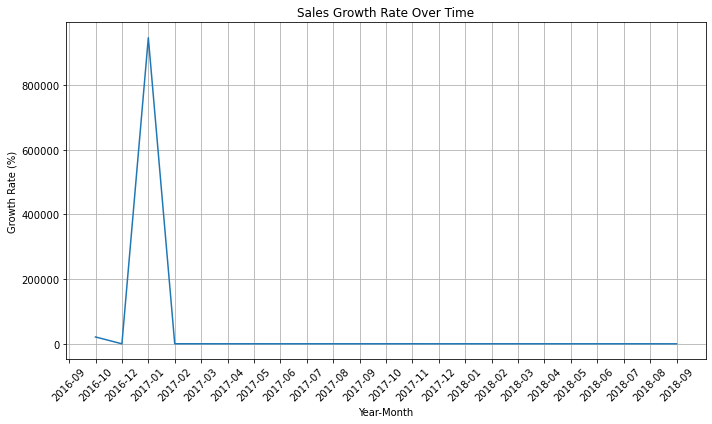

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'timestamp' is the timestamp column and 'payment_value' is the sales column
# Convert 'timestamp' to a datetime object
sales['order_purchase_timestamp'] = pd.to_datetime(sales['order_purchase_timestamp'], format= '%Y-%m-%d %H:%M:%S')

# Extract month and year from the timestamp
sales['year_month'] = sales['order_purchase_timestamp'].dt.to_period('M')

# Group by month and calculate the total sales for each month
monthly_sales = sales.groupby('year_month')['payment_value'].sum().reset_index()

# Calculate the growth rate
monthly_sales['growth_rate'] = monthly_sales['payment_value'].pct_change() * 100

# Convert 'year_month' to string
monthly_sales['year_month'] = monthly_sales['year_month'].dt.strftime('%Y-%m')

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.ticklabel_format(style='plain')
plt.plot(monthly_sales['year_month'].values, monthly_sales['growth_rate'].values)
plt.title('Sales Growth Rate Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Growth Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:

concat_sales = pd.merge(sales,customer, on = 'customer_id', how='inner')

concat_sales = concat_sales.drop(columns=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','product_name_lenght','product_description_lenght','product_photos_qty',
'product_weight_g',
'product_length_cm',
'product_height_cm',
'product_width_cm'])
concat_sales = pd.merge(concat_sales, new_location, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')


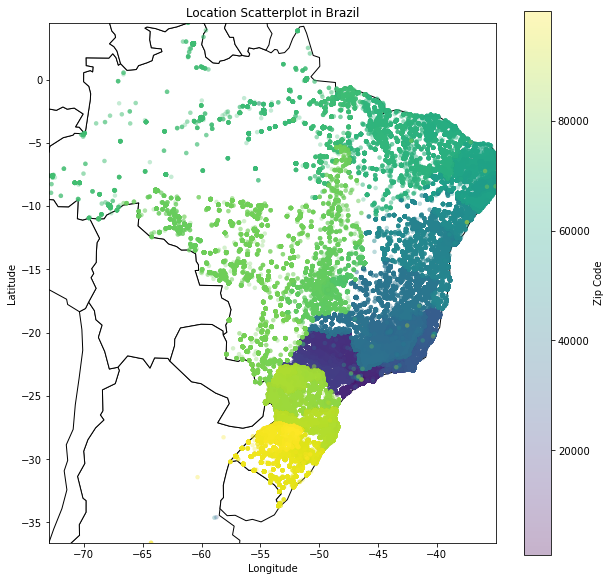

In [15]:
#limit the range locations to remove noise and increase accuracy of the locations
new_location = location[(location['geolocation_lat'] >-50) &
                        (location['geolocation_lat']<10)&
                        (location['geolocation_lng']>-80)&
                        (location['geolocation_lng']<-35)]

import geopandas as gpd

# Read the shapefile into a GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Assuming new_location is your GeoDataFrame with latitude and longitude columns
min_lat, max_lat = new_location['geolocation_lat'].min(), new_location['geolocation_lat'].max()
min_lon, max_lon = new_location['geolocation_lng'].min(), new_location['geolocation_lng'].max()

world = world.cx[min_lon:max_lon, min_lat:max_lat]

ax = world[world.continent == "South America"].plot(color ="white", edgecolor = "black", figsize=(10,10))

scatter = plt.scatter(
    new_location['geolocation_lng'],
    new_location['geolocation_lat'],
    s=20,  # Adjust the marker size as needed
    c=new_location['geolocation_zip_code_prefix'],  # Use zip codes for color
    cmap='viridis',  # Choose a colormap (you can use any Matplotlib colormap)
    edgecolor='none',  # Add edge color for better visibility
    alpha=0.3
)

# Set the plot limits based on the bounding box of your points
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)

# Add a colorbar for the zip codes
cbar = plt.colorbar(scatter, label='Zip Code')

# Add a title and axis labels
plt.title('Location Scatterplot in Brazil')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [16]:

concat_sales = pd.merge(sales,customer, on = 'customer_id', how='inner')

concat_sales = concat_sales.drop(columns=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','product_name_lenght','product_description_lenght','product_photos_qty',
'product_weight_g',
'product_length_cm',
'product_height_cm',
'product_width_cm'])
concat_sales = pd.merge(concat_sales, new_location, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')
concat_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17576439 entries, 0 to 17576438
Data columns (total 24 columns):
 #   Column                         Dtype    
---  ------                         -----    
 0   order_id                       object   
 1   payment_sequential             int64    
 2   payment_type                   object   
 3   payment_installments           int64    
 4   payment_value                  float64  
 5   order_item_id                  int64    
 6   product_id                     object   
 7   seller_id                      object   
 8   shipping_limit_date            object   
 9   price                          float64  
 10  freight_value                  float64  
 11  customer_id                    object   
 12  order_status                   object   
 13  product_category_name_english  object   
 14  year_month                     period[M]
 15  customer_unique_id             object   
 16  customer_zip_code_prefix       int64    
 17  custom

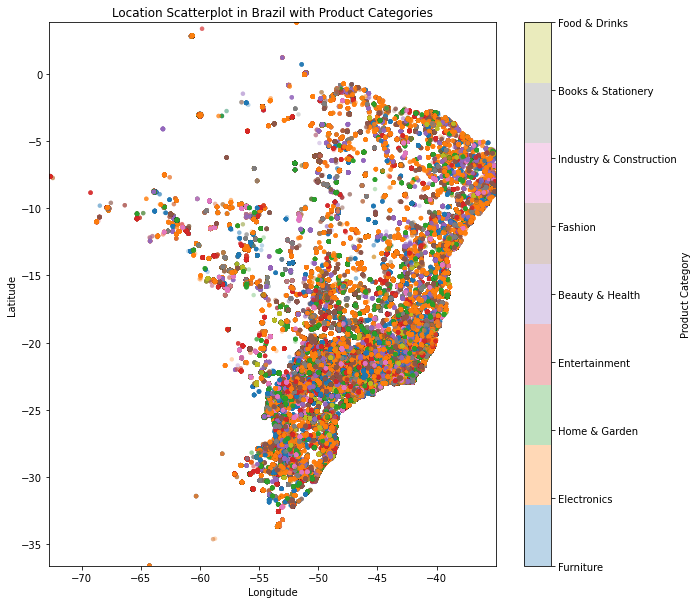

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming concat_sales is your GeoDataFrame with latitude, longitude, and product_category_name_english columns
min_lat, max_lat = concat_sales['geolocation_lat'].min(), concat_sales['geolocation_lat'].max()
min_lon, max_lon = concat_sales['geolocation_lng'].min(), concat_sales['geolocation_lng'].max()

# Filter the world GeoDataFrame to only include the bounding box of your points
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.cx[min_lon:max_lon, min_lat:max_lat]

# Get unique categories and assign a unique color to each category
categories = concat_sales['product_category_name_english'].unique()
category_colors = plt.cm.tab10.colors[:len(categories)]

# Create a colormap
cmap = ListedColormap(category_colors)

# Map category names to colors
color_mapping = concat_sales['product_category_name_english'].map(dict(zip(categories, range(len(categories)))))

# Create a scatter plot based on location with colors representing product categories
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(
    concat_sales['geolocation_lng'],
    concat_sales['geolocation_lat'],
    s=20,  # Adjust the marker size as needed
    c=color_mapping,  # Use mapped colors
    cmap=cmap,  # Use the defined colormap
    edgecolor='none',  # Remove the black circle edges
    alpha=0.3,  # Set alpha to 0.8 for transparency
)

# Set the plot limits based on the bounding box of your points
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Add a colorbar for the product categories
cbar = plt.colorbar(scatter, ticks=range(len(categories)), label='Product Category')
cbar.set_ticklabels(categories)

# Add a title and axis labels
plt.title('Location Scatterplot in Brazil with Product Categories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

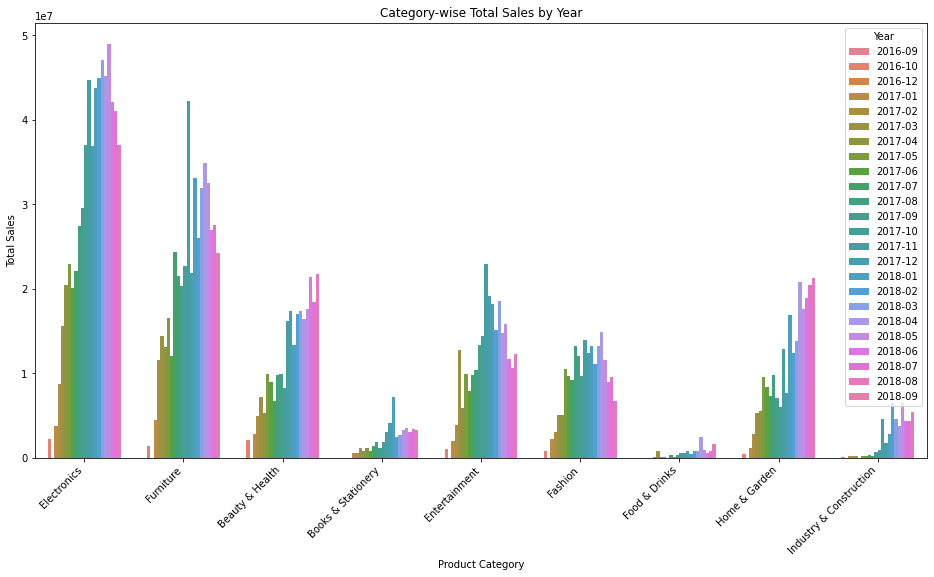

In [18]:
count_sales = concat_sales.groupby(['year_month', 'product_category_name_english'])['price'].sum().reset_index()

custom_palette = sns.color_palette("husl", 24)
plt.figure(figsize=(16, 8))
sns.barplot(x='product_category_name_english', y='price', hue='year_month', data=count_sales, palette=custom_palette)
plt.title('Category-wise Total Sales by Year')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year')
plt.show()